<a href="https://colab.research.google.com/github/skredenmathias/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# Data Cleaning / Exploration

In [7]:
df.shape

(421, 59)

In [61]:
df2['Volume'].isna().sum()

141

In [0]:
df.describe()

In [0]:
df['Queso'].describe()

In [0]:
df.isnull().sum()

In [0]:
sorted(df.isnull().mean()) # remove columns with over 20% NaN values

In [20]:
# remove columns with over 20% NaN values
df.columns[df.isnull().mean() < 0.2]

Index(['Burrito', 'Date', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat',
       'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap',
       'Great'],
      dtype='object')

In [0]:
df = df[df.columns[df.isnull().mean() < 0.2]]

In [23]:
df.isna().sum() # No more NaN values.f

Burrito          0
Date             0
Cost             7
Hunger           3
Tortilla         0
Temp            20
Meat            14
Fillings         3
Meat:filling     9
Uniformity       2
Salsa           25
Synergy          2
Wrap             3
Great            0
dtype: int64

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 422
Data columns (total 14 columns):
Burrito         356 non-null object
Date            356 non-null object
Cost            356 non-null float64
Hunger          356 non-null float64
Tortilla        356 non-null float64
Temp            356 non-null float64
Meat            356 non-null float64
Fillings        356 non-null float64
Meat:filling    356 non-null float64
Uniformity      356 non-null float64
Salsa           356 non-null float64
Synergy         356 non-null float64
Wrap            356 non-null float64
Great           356 non-null bool
dtypes: bool(1), float64(11), object(2)
memory usage: 39.3+ KB


In [12]:
df.shape

(421, 59)

In [0]:
# Fill the NaN values with their respected medians
# df.apply(lambda x: x.fillna(x.median())) 
# [df[col].fillna(df[col].median(), inplace=True) for col in df.columns]

# Temporary solution: Drop rows with NaNs.
df = df.dropna()

In [29]:
df
df.shape # Lost about 65 rows.

(356, 14)

In [32]:
df['Burrito'].dtypes

dtype('O')

In [0]:
df.isna().sum()

## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
from sklearn.model_selection import train_test_split

In [35]:
df['Date'].head()

0    1/18/2016
1    1/24/2016
2    1/24/2016
3    1/24/2016
4    1/27/2016
Name: Date, dtype: object

In [0]:
train = df[df['Date'] <= '12/31/2016']

In [0]:
train

In [0]:
val = df[(df['Date'] >= '01/01/2017') & (df['Date'] <= '12/31/2017')]

In [0]:
val

In [0]:
test = df[df['Date'] >= '01/01/2018']

In [0]:
test # Significantly more rows in test set.

# Begin with baselines for classification.

In [48]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)
# So the baseline is that a burrito is Great 37% of the time.
# Or The majority class is False.

False    0.628571
True     0.371429
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]

In [0]:
y_pred = [majority_class] * len(y_train)

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.6285714285714286

In [56]:
# Validation accuracy
y_val = val[target]
y_pred = [majority_class] * len(y_val) # We're redefining this. How come.
accuracy_score(y_val, y_pred) # Same answer because they have same length.

0.6285714285714286

# 5 Steps

# Use scikit-learn for logistic regression.

In [57]:
df.columns

Index(['Burrito', 'Date', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat',
       'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap',
       'Great'],
      dtype='object')

In [63]:
# Import estimator Class
from sklearn.linear_model import LogisticRegression

# Instantiate the class
log_reg = LogisticRegression(solver='lbfgs')

# Arrange X feature matrices
features = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 
            'Uniformity', 'Salsa', 'Synergy', 'Wrap']
# Currently I have 9 features, because I've dropped Volume, since it has 141
# NaN values.
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Fit the model
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy:', log_reg.score(X_val_imputed, y_val))

Validation Accuracy: 0.9


In [65]:
log_reg.predict(X_val_imputed) # How come they're True/False and not 1/0?

array([False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
        True, False,  True, False, False, False, False, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False,  True, False,  True])

In [67]:
# Coefficients
# log_reg.predict()
pd.Series(log_reg.coef_[0], features)

Tortilla        0.691556
Temp           -0.043712
Meat            1.028032
Fillings        1.057410
Meat:filling    1.061375
Uniformity      0.744097
Salsa           0.425783
Synergy         0.673412
Wrap           -0.449286
dtype: float64

In [0]:
# test_case = [[]]

In [68]:
log_reg.intercept_

array([-19.54130748])

# LogRegCV

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

features = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 
            'Uniformity', 'Salsa', 'Synergy', 'Wrap']
# Should already be defined, but to have it all in one place.
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [78]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((70, 9), (70,), (70, 9), (70,))

In [73]:
# One Hot Encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Imputing
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Logistic Regression CV
model = LogisticRegressionCV(cv=5)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy:', model.score(X_val_scaled, y_val))

Validation Accuracy: 0.8857142857142857


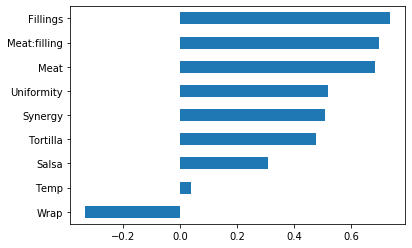

In [74]:
# Plot coefficients
# %matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

# Get your model's test accuracy. (One time, at the end.)

In [0]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

In [0]:
y_test = test[target]

In [84]:
(y_test == y_pred).sum() / len(y_test)

0.8426966292134831

In [85]:
accuracy_score(y_test, y_pred)

0.8426966292134831

# Sigmoid

In [0]:
# Sigmoid
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.e**(-x))

In [0]:
# sigmoid (log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

# Univariate Feature Selection

In [93]:
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif
for k in range(1, len(X_train.columns) +1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_classif, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LogisticRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test mae: {mae:,.2f} \n')

1 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TypeError: ignored